# 2. Cálculo global y descomposición del OEE
En base a los hallazgos del análisis exploratorio, en este notebook vamos a calcular los tres grandes multiplicadores que componen el **OEE (Overall Equipment Effectiveness)**: Disponibilidad, Rendimiento y Calidad. Finalmente, graficaremos estos resultados comparando cada máquina para tener un diagnóstico numérico integral.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuración de estilo y visualizaciones
sns.set_theme(style="whitegrid")
if not os.path.exists('../visualizaciones'):
    os.makedirs('../visualizaciones')

print("Cargando los datos crudos...")
df = pd.read_csv('../datos/raw_data.csv')
df['interval_start'] = pd.to_datetime(df['interval_start'], format='mixed')

# 1. Diccionarios y estandarización
nombres_equipos = {
    's_1': 'Máquina 1', 's_2': 'Máquina 2', 's_3': 'Máquina 3',
    's_4': 'Máquina 4', 's_5': 'Máquina 5'
}
df['equipo_nombre'] = df['equipment_ID'].map(nombres_equipos).fillna(df['equipment_ID'])

traduccion_estados = {
    'idle': 'Inactividad (Idle)',
    'scheduled_downtime': 'Mantenimiento Planeado',
    'performance_loss': 'Pérdida de Rendimiento',
    'downtime': 'Falla de Equipo (Downtime)',
    'production': 'Producción'
}
df['tipo_estado'] = df['type'].map(traduccion_estados).fillna(df['type'])

print("Datos cargados exitosamente.")

Cargando los datos crudos...
Datos cargados exitosamente.


### 1. Desarrollo del Cálculo del OEE

Para calcular el OEE agruparemos los datos para cada equipo:
* **Disponibilidad (Availability)**: Tiempo Operativo (periodos de 'Producción' activa) / Tiempo Planeado de Producción (Tiempo total - Mantenimiento Planeado).
* **Rendimiento (Performance)**: Piezas reales de entrada `pi` / Producción máxima esperada (Tiempo Operativo * Velocidad nominal `speed`).
* **Calidad (Quality)**: Piezas aptas y terminadas `po` / Total de piezas fabricadas `pi`.

In [2]:
print("Calculando Disponibilidad, Rendimiento, Calidad y OEE final...")
equipos = df['equipo_nombre'].unique()
equipos.sort()
oee_data = []

for eq in equipos:
    df_eq = df[df['equipo_nombre'] == eq]
    
    # --- DISPONIBILIDAD ---
    total_time = df_eq['elapsed'].sum()
    scheduled_downtime = df_eq[df_eq['tipo_estado'] == 'Mantenimiento Planeado']['elapsed'].sum()
    planned_production_time = total_time - scheduled_downtime
    
    # Se toma el estado de producción efectiva
    operating_time = df_eq[df_eq['tipo_estado'] == 'Producción']['elapsed'].sum()
    availability = operating_time / planned_production_time if planned_production_time > 0 else 0
    
    # --- RENDIMIENTO ---
    # Incremento total neto del contador 'pi'
    total_pi = df_eq['pi'].max() - df_eq['pi'].min()
    
    # El 'elapsed' se asume medido en milisegundos, por lo cual convertimos a horas. 
    operating_time_hr = operating_time / 1000 / 3600 
    
    # Velocidad máxima/nominal medida para la máquina.
    max_speed_hr = df_eq['speed'].max()
    expected_pi = operating_time_hr * max_speed_hr
    
    performance = total_pi / expected_pi if expected_pi > 0 else 0
    
    # Fallos de sincronización / contadores anómalos suelen empujar arriba de 100%
    if performance > 1.0: performance = 1.0
    
    # --- CALIDAD ---
    # Piezas resultantes 'po'
    total_po = df_eq['po'].max() - df_eq['po'].min()
    quality = total_po / total_pi if total_pi > 0 else 0
    
    # --- OEE TOTAL ---
    oee = availability * performance * quality
    
    oee_data.append({
        'Equipo': eq,
        'Disponibilidad': availability * 100,
        'Rendimiento': performance * 100,
        'Calidad': quality * 100,
        'OEE': oee * 100
    })

oee_df = pd.DataFrame(oee_data)
display(oee_df.round(2))

Calculando Disponibilidad, Rendimiento, Calidad y OEE final...


,Equipo,Disponibilidad,Rendimiento,Calidad,OEE
0,Máquina 1,64.71,100.00,99.59,64.45
1,Máquina 2,32.58,100.00,100.17,32.64
2,Máquina 3,44.69,100.00,99.76,44.59
3,Máquina 4,44.00,4.58,99.16,2.00
4,Máquina 5,53.38,100.00,83.12,44.37


### 2. Visualización de los Componentes OEE

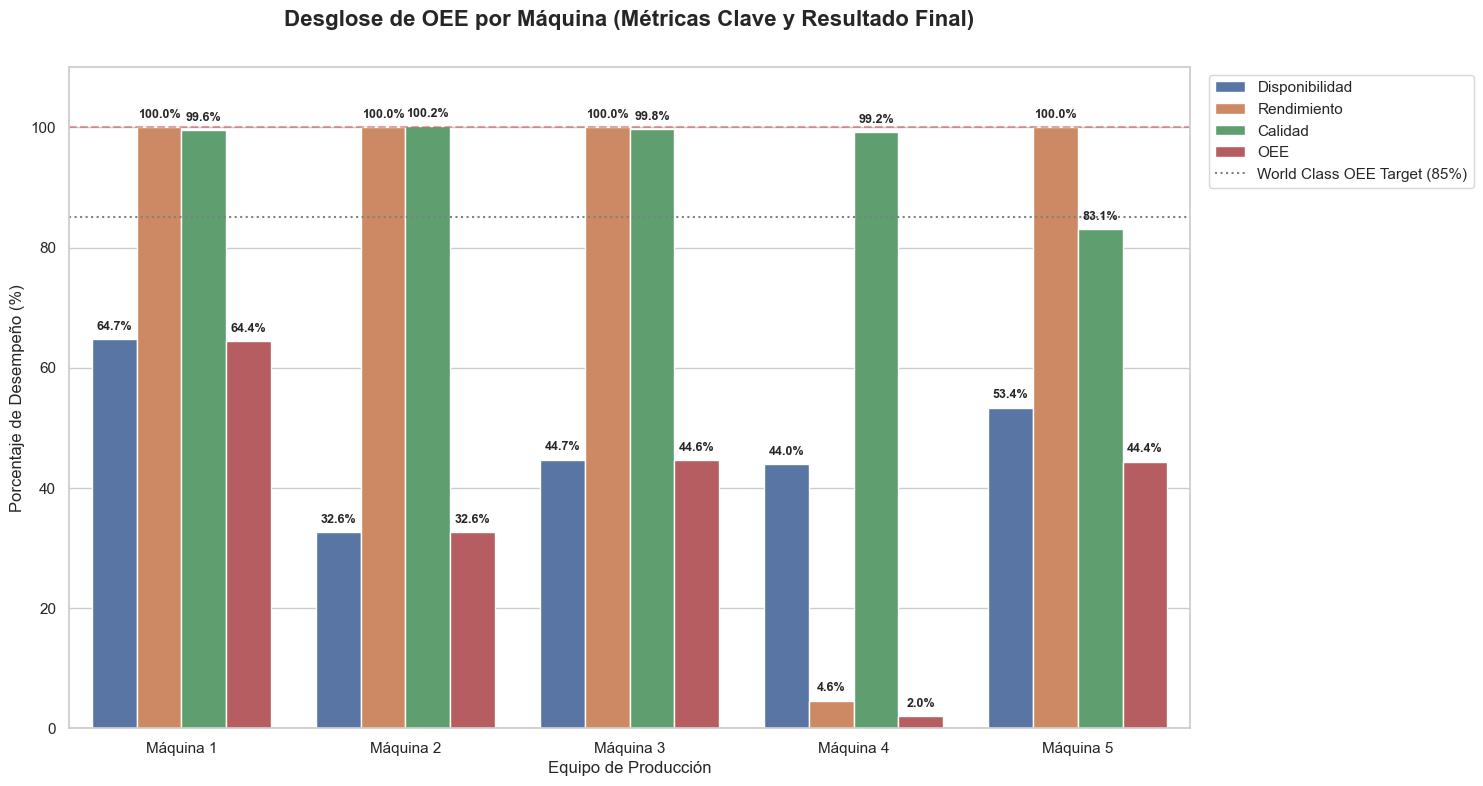


--- PROMEDIOS GENERALES DE LA PLANTA --- 
Disponibilidad    47.87
Rendimiento       80.92
Calidad           96.36
OEE               37.61
dtype: float64


In [3]:
# Transformar para gráfico agrupado (Melt de Pandas)
oee_melted = pd.melt(oee_df, id_vars=['Equipo'], value_vars=['Disponibilidad', 'Rendimiento', 'Calidad', 'OEE'],
                    var_name='Métrica', value_name='Porcentaje')

plt.figure(figsize=(15, 8))
ax = sns.barplot(data=oee_melted, x='Equipo', y='Porcentaje', hue='Métrica', palette='deep')

plt.title('Desglose de OEE por Máquina (Métricas Clave y Resultado Final)', y=1.05, fontsize=16, fontweight='bold')
plt.ylabel('Porcentaje de Desempeño (%)', fontsize=12)
plt.xlabel('Equipo de Producción', fontsize=12)
plt.ylim(0, 110)
plt.axhline(y=100, color='r', linestyle='--', alpha=0.5)
plt.axhline(y=85, color='gray', linestyle=':', label='World Class OEE Target (85%)')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

# Añadimos las etiquetas para máxima decodificación visual
for p in ax.patches:
    valor = p.get_height()
    if valor > 0:
        ax.annotate(f'{valor:.1f}%', 
                    (p.get_x() + p.get_width() / 2., valor),
                    ha='center', va='center', xytext=(0, 9), 
                    textcoords='offset points', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('../visualizaciones/oee_componentes.png', dpi=300)
plt.show()

print("\n--- PROMEDIOS GENERALES DE LA PLANTA --- ")
promedios = oee_df[['Disponibilidad', 'Rendimiento', 'Calidad', 'OEE']].mean()
print(promedios.round(2))